In [5]:
import jax
import jax.numpy as jnp
from chewc.population import quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import gblup_predict
from chewc.population import combine_populations, Population
import matplotlib.pyplot as plt
from chewc.population import quick_haplo, combine_populations, Population, subset_population # Add subset_population
from matplotlib.pyplot as plt

SyntaxError: invalid syntax (2183600011.py, line 12)

In [6]:
import jax
import jax.numpy as jnp
from chewc.population import msprime_pop

# Define parameters for the founder population
n_ind = 200
n_loci_per_chr = 1000
n_chr = 5

# Create a JAX random key
key = jax.random.PRNGKey(42)

# Create the msprime founder population
founder_pop, genetic_map = msprime_pop(
    key=key,
    n_ind=n_ind,
    n_loci_per_chr=n_loci_per_chr,
    n_chr=n_chr
)

# Print the founder population to verify
print(founder_pop)
print("Genetic map shape:", genetic_map.shape)

Population(nInd=200, nTraits=0, has_ebv=No)
Genetic map shape: (5, 1000)


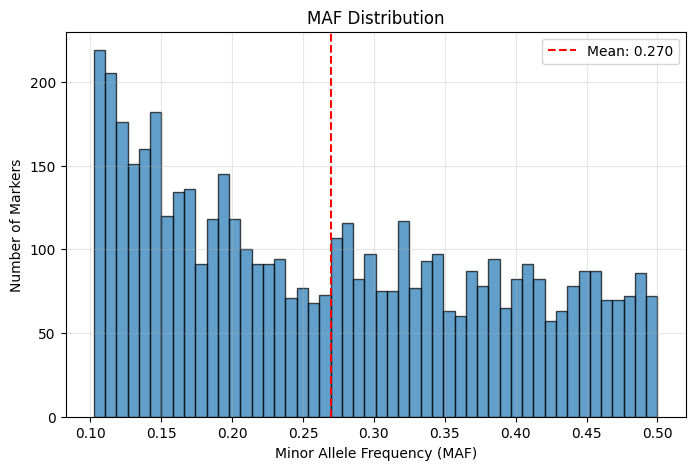

Markers: 5000 | Fixed: 0 | Mean MAF: 0.270


In [7]:
founder_pop.plot_maf()

sp1 (gamma=False): SimParam(nChr=5, nTraits=1, ploidy=2, sexes='no')
sp2 (gamma=True, shape=0.4): SimParam(nChr=5, nTraits=1, ploidy=2, sexes='no')


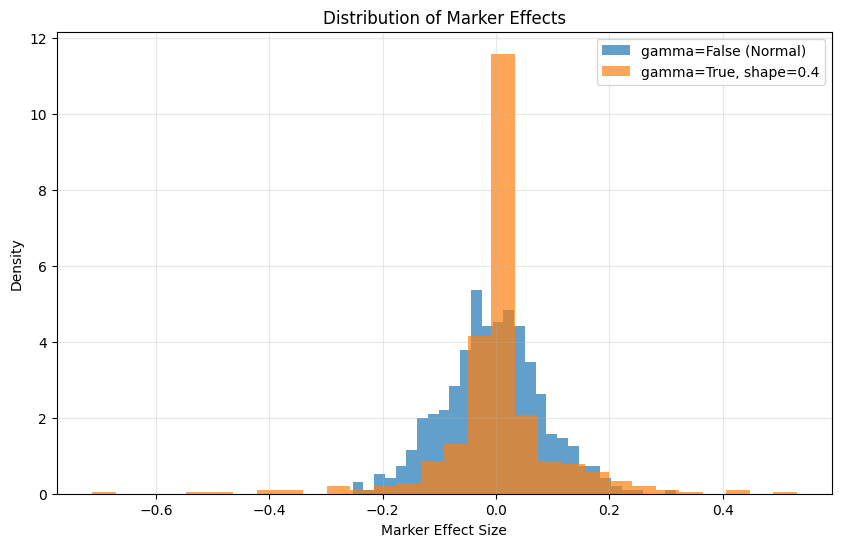

Generation 0: Mean BV = -0.4698, Var BV = 2.0000
Generation 1: Mean BV = 1.6721, Var BV = 1.2121
Generation 2: Mean BV = 3.1091, Var BV = 0.9883
Generation 3: Mean BV = 4.4767, Var BV = 0.8778
Generation 4: Mean BV = 5.7171, Var BV = 0.5946
Generation 5: Mean BV = 6.6369, Var BV = 0.4837
Generation 6: Mean BV = 7.5570, Var BV = 0.3730
Generation 7: Mean BV = 8.4038, Var BV = 0.3262
Generation 8: Mean BV = 9.1772, Var BV = 0.3313
Generation 9: Mean BV = 10.0514, Var BV = 0.2657
Generation 10: Mean BV = 10.8273, Var BV = 0.2297
Generation 11: Mean BV = 11.4898, Var BV = 0.3075
Generation 12: Mean BV = 12.2215, Var BV = 0.2853
Generation 13: Mean BV = 12.8395, Var BV = 0.2085
Generation 14: Mean BV = 13.4655, Var BV = 0.1403
Generation 15: Mean BV = 13.9379, Var BV = 0.1359
Generation 16: Mean BV = 14.4668, Var BV = 0.1325
Generation 17: Mean BV = 14.8296, Var BV = 0.1145
Generation 18: Mean BV = 15.3661, Var BV = 0.1025
Generation 19: Mean BV = 15.7921, Var BV = 0.0532
Generation 20: Mea

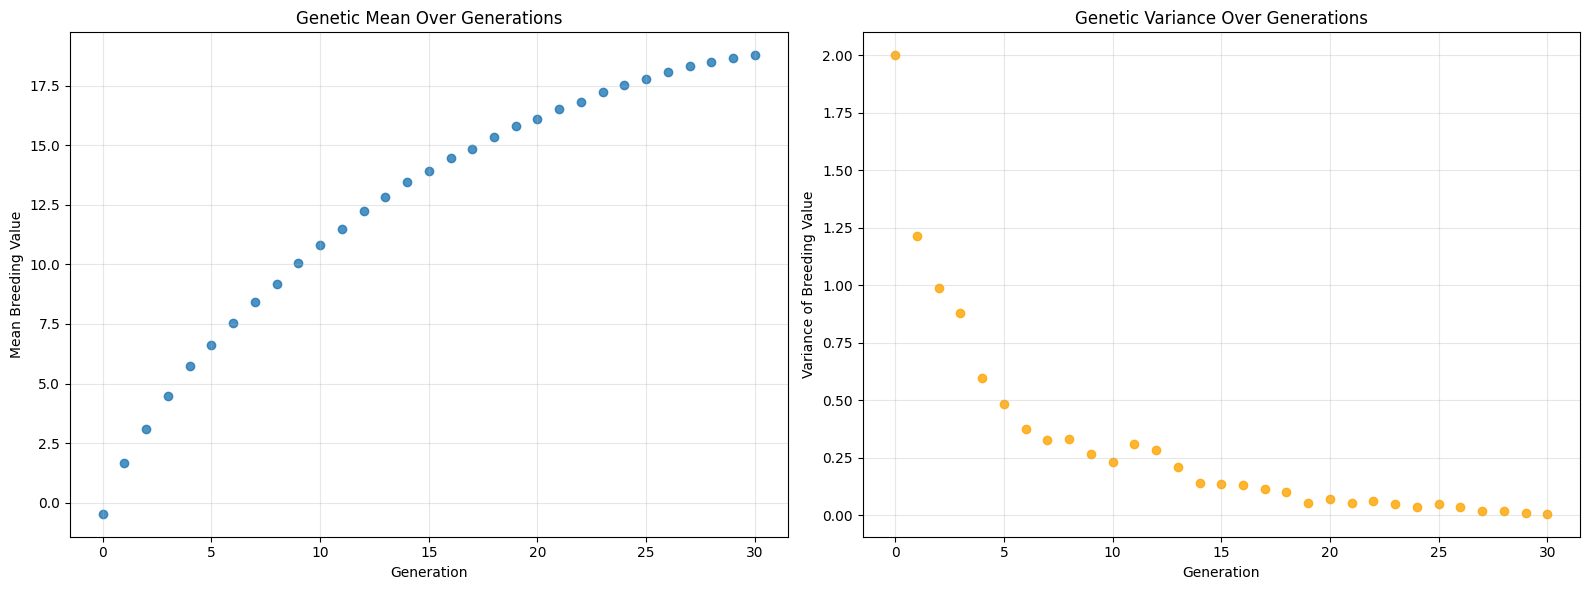

In [26]:
from chewc.phenotype import *
from chewc.cross import *


# --- Simulation Parameters ---
N_GENERATIONS = 30
POPULATION_SIZE = 200
N_SELECT = 20
HERITABILITY = 0.6

# --- Data Storage ---
genetic_means = []
genetic_variances = []

# --- Initial Population Setup ---
# Start with the founder population
current_pop = founder_pop
next_id_start = current_pop.nInd


# Split the main key for all simulation steps
key, pheno_key, select_key, mate_key = jax.random.split(key, 4)


for gen in range(N_GENERATIONS + 1):
    # Split keys for the current generation's operations
    pheno_key, p_subkey = jax.random.split(pheno_key)
    select_key, s_subkey = jax.random.split(select_key)
    mate_key, m_subkey1, m_subkey2 = jax.random.split(mate_key, 3)

    # 1. Calculate and store genetic mean and variance for the current population
    current_pop = set_bv(current_pop, sp1.traits, sp1.ploidy)
    mean_bv = jnp.mean(current_pop.bv)
    var_bv = jnp.var(current_pop.bv)
    genetic_means.append(mean_bv)
    genetic_variances.append(var_bv)
    print(f"Generation {gen}: Mean BV = {mean_bv:.4f}, Var BV = {var_bv:.4f}")

    # 2. Phenotype the population
    current_pop = set_pheno(
        key=p_subkey,
        pop=current_pop,
        traits=sp1.traits,
        ploidy=sp1.ploidy,
        h2=jnp.array([HERITABILITY])
    )

    # 3. Select the top parents based on phenotype
    # Using argsort to get indices of top individuals
    # The values are sorted in ascending order, so we take the last N_SELECT indices
    selected_indices = jnp.argsort(current_pop.pheno[:, 0])[-N_SELECT:]


    # 4. Randomly mate selected parents to create the next generation
    # Randomly choose mothers and fathers from the selected group
    mothers = jax.random.choice(m_subkey1, selected_indices, shape=(POPULATION_SIZE,))
    fathers = jax.random.choice(m_subkey2, selected_indices, shape=(POPULATION_SIZE,))
    cross_plan = jnp.stack([mothers, fathers], axis=1)

    # 5. Create the next generation
    current_pop = make_cross(
        key=select_key,  # Re-using select_key for the cross
        pop=current_pop,
        cross_plan=cross_plan,
        sp=sp1,
        next_id_start=next_id_start
    )
    next_id_start += POPULATION_SIZE


generations = range(N_GENERATIONS + 1)

# --- Create the plots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Genetic Mean
ax1.scatter(generations, genetic_means, alpha=0.8)
ax1.set_title("Genetic Mean Over Generations")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Breeding Value")
ax1.grid(True, alpha=0.3)

# Plot Genetic Variance
ax2.scatter(generations, genetic_variances, alpha=0.8, color='orange')
ax2.set_title("Genetic Variance Over Generations")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Variance of Breeding Value")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
generations

range(0, 11)

[{'color': 'blue',
  'h2': 0.1,
  'name': 'sp1 (Normal), h2=0.1',
  'sp': SimParam(nChr=5, nTraits=1, ploidy=2, sexes='no')},
 {'color': 'red',
  'h2': 0.6,
  'name': 'sp1 (Normal), h2=0.6',
  'sp': SimParam(nChr=5, nTraits=1, ploidy=2, sexes='no')},
 {'color': 'green',
  'h2': 0.1,
  'name': 'sp2 (Gamma), h2=0.1',
  'sp': SimParam(nChr=5, nTraits=1, ploidy=2, sexes='no')},
 {'color': 'purple',
  'h2': 0.6,
  'name': 'sp2 (Gamma), h2=0.6',
  'sp': SimParam(nChr=5, nTraits=1, ploidy=2, sexes='no')}]
Running: sp1 (Normal), h2=0.1
Running: sp1 (Normal), h2=0.6
Running: sp2 (Gamma), h2=0.1
Running: sp2 (Gamma), h2=0.6


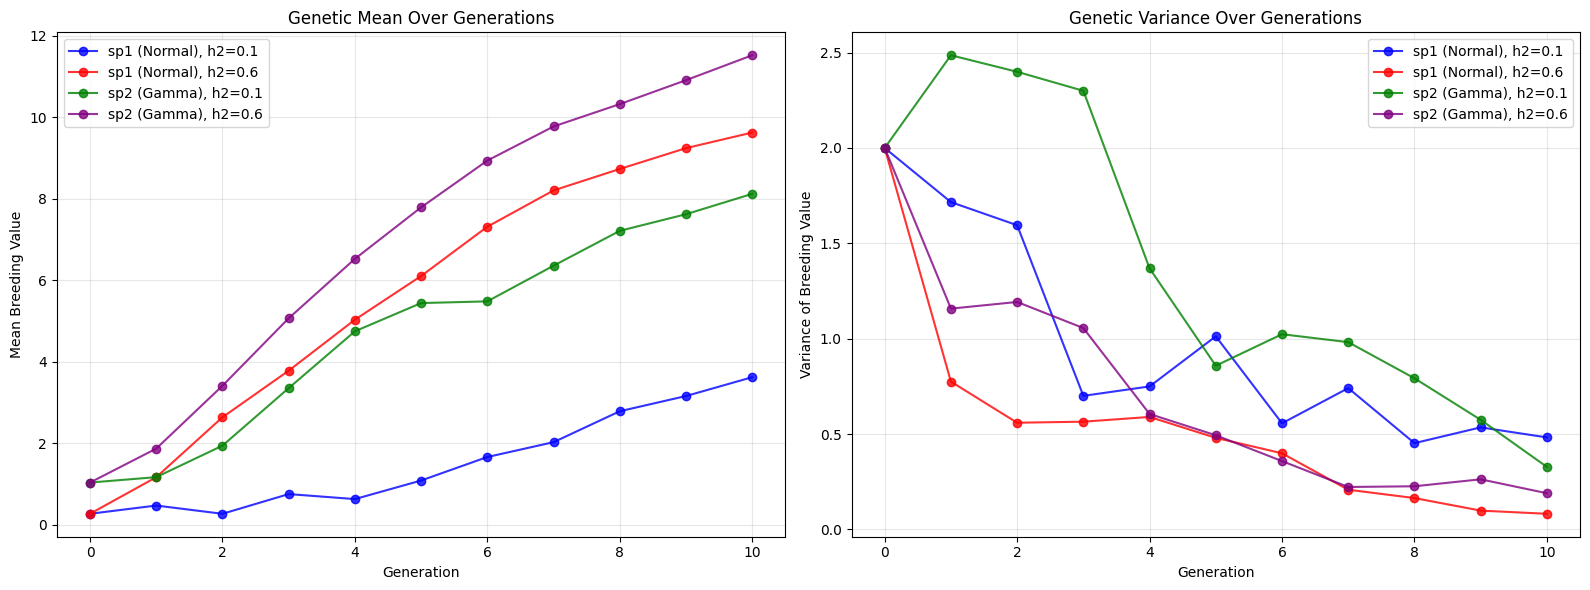

In [41]:
def run_simulation(key, founder_pop, sp, heritability, params):
    """Runs a breeding simulation for a given number of generations."""
    genetic_means = []
    genetic_variances = []

    current_pop = founder_pop
    next_id_start = current_pop.nInd

    # Use parameters from the params dictionary
    n_generations = params["n_generations"]
    population_size = params["population_size"]
    n_select = params["n_select"]
    
    pheno_key, select_key, mate_key = jax.random.split(key, 3)

    for gen in range(n_generations + 1):
        p_subkey, pheno_key = jax.random.split(pheno_key)
        s_subkey, select_key = jax.random.split(select_key)
        m_subkey1, m_subkey2, mate_key = jax.random.split(mate_key, 3)
        
        current_pop = set_bv(current_pop, sp.traits, sp.ploidy)
        mean_bv = jnp.mean(current_pop.bv)
        var_bv = jnp.var(current_pop.bv)
        genetic_means.append(mean_bv)
        genetic_variances.append(var_bv)

        current_pop = set_pheno(
            key=p_subkey, pop=current_pop, traits=sp.traits,
            ploidy=sp.ploidy, h2=jnp.array([heritability])
        )

        selected_indices = jnp.argsort(current_pop.pheno[:, 0])[-n_select:]

        mothers = jax.random.choice(m_subkey1, selected_indices, shape=(population_size,))
        fathers = jax.random.choice(m_subkey2, selected_indices, shape=(population_size,))
        cross_plan = jnp.stack([mothers, fathers], axis=1)

        current_pop = make_cross(
            key=s_subkey, pop=current_pop, cross_plan=cross_plan,
            sp=sp, next_id_start=next_id_start
        )
        next_id_start += population_size

    return genetic_means, genetic_variances


import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from chewc.population import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross

# ==================================================
# ---  simulation_parameters ---
# ==================================================
# Use a dictionary to hold all our parameters for easy access and modification.
simulation_parameters = {
    # Founder Population Settings
    "n_founder_ind": 20,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    
    # Trait Architecture
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([10.0]),
    "trait_var": jnp.array([2.0]),
    
    # Breeding Program Settings
    "n_generations": 10,
    "population_size": 200,
    "n_select": 10, # Number of parents to select each generation
    
    # PRNGKey for reproducibility
    "key": jax.random.PRNGKey(42)
}
# ==================================================

# --- Setup Founder Population and Traits using Parameters ---
key = simulation_parameters["key"]
key, founder_key, sp1_key, sp2_key = jax.random.split(key, 4)

founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"]
)

# Create SimParam objects for sp1 (Normal) and sp2 (Gamma)
sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key, founder_pop=founder_pop, sim_param=sp1,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"],
    gamma=False
)

sp2 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp2 = add_trait_a(
    key=sp2_key, founder_pop=founder_pop, sim_param=sp2,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"],
    gamma=True, shape=0.4
)

# Define the base templates for each simulation group
scenario_templates = [
    {"name_base": "sp1 (Normal)", "sp": sp1, "color": "blue"},
    {"name_base": "sp2 (Gamma)", "sp": sp2, "color": "green"}
]

# Define the heritabilities you want to test
h2_values_to_test = [0.1, 0.6]

# Dynamically assign colors for different h2 values if you want
# For simplicity, we can just alternate or use a predefined map.
h2_colors = {"0.1": "blue", "0.6": "red"} # Example color mapping


scenarios = []
for template in scenario_templates:
    for h2 in h2_values_to_test:
        # Create a new scenario dictionary for each combination
        scenarios.append({
            # Dynamically create the name using the base and h2 value
            "name": f"{template['name_base']}, h2={h2}",
            "sp": template['sp'],
            "h2": h2,
            # You can get creative with colors, e.g., use different shades
            "color": template['color'] if h2 == 0.1 else template['color'].replace('blue', 'red').replace('green', 'purple')
        })

# You can print the generated scenarios to verify
import pprint
pprint.pprint(scenarios)

results = {}
for scenario in scenarios:
    key, sim_key = jax.random.split(key)
    print(f"Running: {scenario['name']}")
    means, variances = run_simulation(
        key=sim_key,
        founder_pop=founder_pop,
        sp=scenario["sp"],
        heritability=scenario["h2"],
        params=simulation_parameters  # Pass the whole dict
    )
    results[scenario['name']] = {"means": means, "variances": variances, "color": scenario["color"]}

# --- Visualization (Unchanged) ---
generations = range(simulation_parameters["n_generations"] + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Genetic Mean
for name, data in results.items():
    ax1.plot(generations, data["means"], marker='o', linestyle='-', label=name, color=data["color"], alpha=0.8)
ax1.set_title("Genetic Mean Over Generations")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Breeding Value")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Genetic Variance
for name, data in results.items():
    ax2.plot(generations, data["variances"], marker='o', linestyle='-', label=name, color=data["color"], alpha=0.8)
ax2.set_title("Genetic Variance Over Generations")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Variance of Breeding Value")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Running: Normal, h2=0.1
Running: Normal, h2=0.6
Running: Gamma, h2=0.1
Running: Gamma, h2=0.6


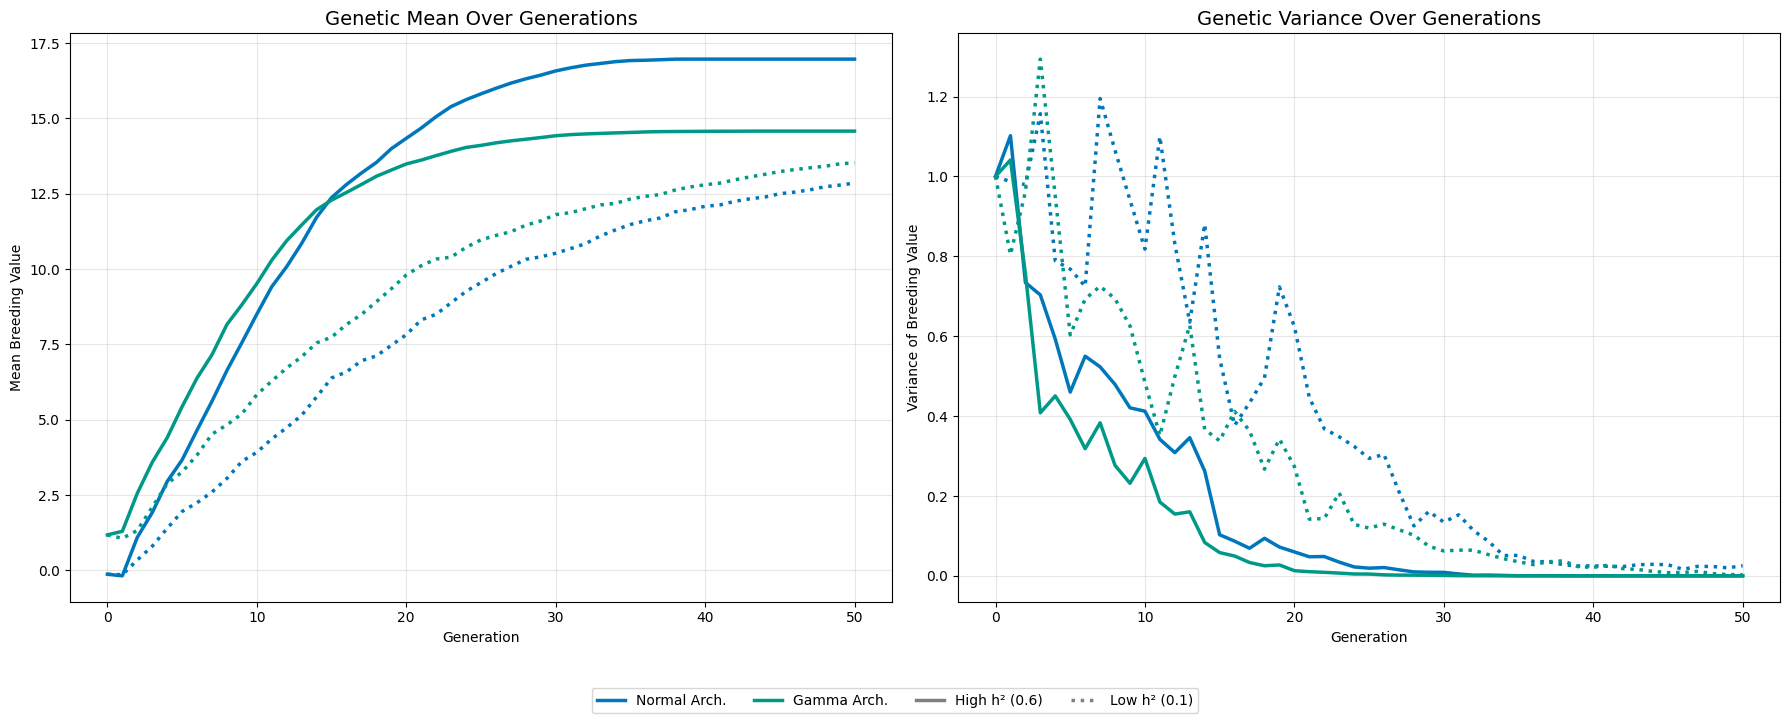

In [52]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from chewc.population import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross

# ==================================================
# ---  simulation_parameters ---
# ==================================================
simulation_parameters = {
    "n_founder_ind": 10,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 50,
    "population_size": 200,
    "n_select": 20,
    "key": jax.random.PRNGKey(42)
}
# ==================================================

def run_simulation(key, founder_pop, sp, heritability, params):
    """Runs a breeding simulation for a given number of generations."""
    genetic_means = []
    genetic_variances = []
    current_pop = founder_pop
    next_id_start = current_pop.nInd
    n_generations = params["n_generations"]
    population_size = params["population_size"]
    n_select = params["n_select"]
    pheno_key, select_key, mate_key = jax.random.split(key, 3)

    for gen in range(n_generations + 1):
        p_subkey, pheno_key = jax.random.split(pheno_key)
        s_subkey, select_key = jax.random.split(select_key)
        m_subkey1, m_subkey2, mate_key = jax.random.split(mate_key, 3)
        current_pop = set_bv(current_pop, sp.traits, sp.ploidy)
        genetic_means.append(jnp.mean(current_pop.bv))
        genetic_variances.append(jnp.var(current_pop.bv))
        current_pop = set_pheno(
            key=p_subkey, pop=current_pop, traits=sp.traits,
            ploidy=sp.ploidy, h2=jnp.array([heritability])
        )
        selected_indices = jnp.argsort(current_pop.pheno[:, 0])[-n_select:]
        mothers = jax.random.choice(m_subkey1, selected_indices, shape=(population_size,))
        fathers = jax.random.choice(m_subkey2, selected_indices, shape=(population_size,))
        cross_plan = jnp.stack([mothers, fathers], axis=1)
        current_pop = make_cross(
            key=s_subkey, pop=current_pop, cross_plan=cross_plan,
            sp=sp, next_id_start=next_id_start
        )
        next_id_start += population_size
    return genetic_means, genetic_variances

# --- Setup Founder Population and Traits ---
key = simulation_parameters["key"]
key, founder_key, sp1_key, sp2_key = jax.random.split(key, 4)
founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"]
)
sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key, founder_pop=founder_pop, sim_param=sp1,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"], var=simulation_parameters["trait_var"],
    gamma=False
)
sp2 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp2 = add_trait_a(
    key=sp2_key, founder_pop=founder_pop, sim_param=sp2,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"], var=simulation_parameters["trait_var"],
    gamma=True, shape=0.4
)

# --- Define Scenarios with new aesthetic mappings ---
scenario_templates = [
    {"name_base": "Normal", "sp": sp1, "color": "#0077BB"}, # Blue
    {"name_base": "Gamma", "sp": sp2, "color": "#009988"}  # Teal
]
h2_values_to_test = [0.1, 0.6]
h2_linestyles = {0.1: ':', 0.6: '-'}

scenarios = []
for template in scenario_templates:
    for h2 in h2_values_to_test:
        scenarios.append({
            "name": f"{template['name_base']}, h2={h2}",
            "sp": template['sp'], "h2": h2,
            "color": template['color'], "linestyle": h2_linestyles[h2]
        })

# --- Run Simulations ---
results = {}
for scenario in scenarios:
    key, sim_key = jax.random.split(key)
    print(f"Running: {scenario['name']}")
    means, variances = run_simulation(
        key=sim_key, founder_pop=founder_pop, sp=scenario["sp"],
        heritability=scenario["h2"], params=simulation_parameters
    )
    results[scenario['name']] = {
        "means": means, "variances": variances,
        "color": scenario["color"], "linestyle": scenario["linestyle"]
    }

# ==================================================
# --- NEW: Combined Visualization with Best Practices ---
# ==================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
generations = range(simulation_parameters["n_generations"] + 1)

# --- Plot 1: Genetic Mean ---
ax1.set_title("Genetic Mean Over Generations", fontsize=14)
for name, data in results.items():
    ax1.plot(
        generations, data["means"], marker='',
        linestyle=data["linestyle"], color=data["color"], linewidth=2.5
    )
ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Breeding Value")
ax1.grid(True, alpha=0.3)

# --- Plot 2: Genetic Variance ---
ax2.set_title("Genetic Variance Over Generations", fontsize=14)
for name, data in results.items():
    ax2.plot(
        generations, data["variances"], marker='',
        linestyle=data["linestyle"], color=data["color"], linewidth=2.5
    )
ax2.set_xlabel("Generation")
ax2.set_ylabel("Variance of Breeding Value")
ax2.grid(True, alpha=0.3)

# --- Create a single, clear, custom legend for the entire figure ---
legend_elements = [
    mlines.Line2D([], [], color='#0077BB', linestyle='-', lw=2.5, label='Normal Arch.'),
    mlines.Line2D([], [], color='#009988', linestyle='-', lw=2.5, label='Gamma Arch.'),
    mlines.Line2D([], [], color='gray', linestyle='-', lw=2.5, label='High h² (0.6)'),
    mlines.Line2D([], [], color='gray', linestyle=':', lw=2.5, label='Low h² (0.1)')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4)

plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for the legend
plt.show()

In [ ]:
from chewc.sp import SimParam
from chewc.trait import *
import matplotlib.pyplot as plt
# --- Define Parameters ---
n_qtl_per_chr = 100
mean = jnp.array([10.0])
var = jnp.array([2.0])

# Split the key for reproducibility
key, sp1_key, sp2_key = jax.random.split(key, 3)

# --- Create and Configure sp1 (Normal distribution) ---
sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key,
    founder_pop=founder_pop,
    sim_param=sp1,
    n_qtl_per_chr=n_qtl_per_chr,
    mean=mean,
    var=var,
    gamma=False
)

# --- Create and Configure sp2 (Gamma distribution) ---
sp2 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp2 = add_trait_a(
    key=sp2_key,
    founder_pop=founder_pop,
    sim_param=sp2,
    n_qtl_per_chr=n_qtl_per_chr,
    mean=mean,
    var=var,
    gamma=True,
    shape=0.4
)

print("sp1 (gamma=False):", sp1)
print("sp2 (gamma=True, shape=0.4):", sp2)

# Extract the additive effects for each trait
effects_sp1 = sp1.traits.add_eff.flatten()
effects_sp2 = sp2.traits.add_eff.flatten()

# --- Create the overlapping histogram ---
plt.figure(figsize=(10, 6))
plt.hist(effects_sp1, bins=30, alpha=0.7, label='gamma=False (Normal)', density=True)
plt.hist(effects_sp2, bins=30, alpha=0.7, label='gamma=True, shape=0.4', density=True)
plt.xlabel("Marker Effect Size")
plt.ylabel("Density")
plt.title("Distribution of Marker Effects")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [53]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np # Using numpy for easier stats calculation on results

from chewc.population import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross

# ==================================================
# ---  simulation_parameters ---
# ==================================================
simulation_parameters = {
    "n_replicates": 10,
    "n_founder_ind": 10,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 100,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 50,
    "population_size": 200,
    "n_select": 20,
    "key": jax.random.PRNGKey(42)
}
# ==================================================

In [55]:
def run_simulation(key, founder_pop, sp, heritability, params):
    """Runs a breeding simulation for a given number of generations."""
    genetic_means = []
    genetic_variances = []
    current_pop = founder_pop
    next_id_start = current_pop.nInd
    n_generations = params["n_generations"]
    population_size = params["population_size"]
    n_select = params["n_select"]
    pheno_key, select_key, mate_key = jax.random.split(key, 3)

    for gen in range(n_generations + 1):
        p_subkey, pheno_key = jax.random.split(pheno_key)
        s_subkey, select_key = jax.random.split(select_key)
        m_subkey1, m_subkey2, mate_key = jax.random.split(mate_key, 3)
        current_pop = set_bv(current_pop, sp.traits, sp.ploidy)
        genetic_means.append(jnp.mean(current_pop.bv))
        genetic_variances.append(jnp.var(current_pop.bv))
        current_pop = set_pheno(
            key=p_subkey, pop=current_pop, traits=sp.traits,
            ploidy=sp.ploidy, h2=jnp.array([heritability])
        )
        selected_indices = jnp.argsort(current_pop.pheno[:, 0])[-n_select:]
        mothers = jax.random.choice(m_subkey1, selected_indices, shape=(population_size,))
        fathers = jax.random.choice(m_subkey2, selected_indices, shape=(population_size,))
        cross_plan = jnp.stack([mothers, fathers], axis=1)
        current_pop = make_cross(
            key=s_subkey, pop=current_pop, cross_plan=cross_plan,
            sp=sp, next_id_start=next_id_start
        )
        next_id_start += population_size
    return genetic_means, genetic_variances

# --- Setup Founder Population and Traits ---
key = simulation_parameters["key"]
key, founder_key, sp1_key, sp2_key = jax.random.split(key, 4)
founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"]
)
sp1 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp1 = add_trait_a(
    key=sp1_key, founder_pop=founder_pop, sim_param=sp1,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"], var=simulation_parameters["trait_var"],
    gamma=False
)
sp2 = SimParam.from_founder_pop(founder_pop, genetic_map)
sp2 = add_trait_a(
    key=sp2_key, founder_pop=founder_pop, sim_param=sp2,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"], var=simulation_parameters["trait_var"],
    gamma=True, shape=0.4
)

# --- Define Scenarios ---
scenario_templates = [
    {"name_base": "Normal", "sp": sp1, "color": "#0077BB"},
    {"name_base": "Gamma", "sp": sp2, "color": "#009988"}
]
h2_values_to_test = [0.1, 0.6]
h2_linestyles = {0.1: ':', 0.6: '-'}

scenarios = []
for template in scenario_templates:
    for h2 in h2_values_to_test:
        scenarios.append({
            "name": f"{template['name_base']}, h2={h2}",
            "sp": template['sp'], "h2": h2,
            "color": template['color'], "linestyle": h2_linestyles[h2]
        })

# --- Run Replicated Simulations ---
results = {s['name']: {'means': [], 'variances': []} for s in scenarios}
for i in range(simulation_parameters["n_replicates"]):
    key, rep_key = jax.random.split(key)
    print(f"--- Running Replicate {i+1}/{simulation_parameters['n_replicates']} ---")
    for scenario in scenarios:
        rep_key, sim_key = jax.random.split(rep_key)
        means, variances = run_simulation(
            key=sim_key, founder_pop=founder_pop, sp=scenario["sp"],
            heritability=scenario["h2"], params=simulation_parameters
        )
        results[scenario['name']]['means'].append(means)
        results[scenario['name']]['variances'].append(variances)

--- Running Replicate 1/10 ---
--- Running Replicate 2/10 ---
--- Running Replicate 3/10 ---
--- Running Replicate 4/10 ---
--- Running Replicate 5/10 ---
--- Running Replicate 6/10 ---
--- Running Replicate 7/10 ---
--- Running Replicate 8/10 ---
--- Running Replicate 9/10 ---
--- Running Replicate 10/10 ---


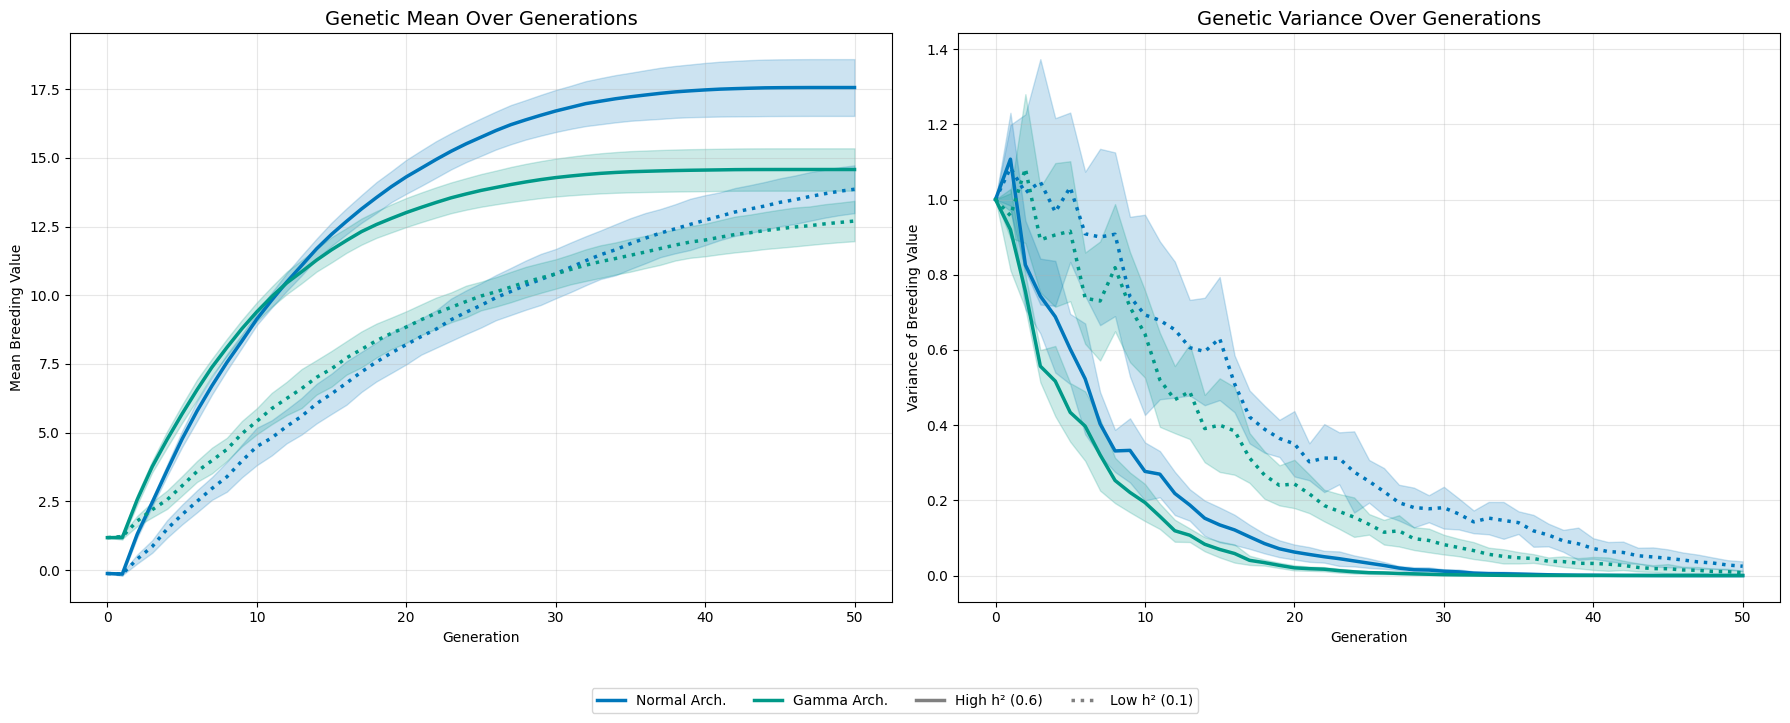

In [56]:
# ==================================================
# --- Visualization with Confidence Intervals ---
# ==================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
generations = range(simulation_parameters["n_generations"] + 1)

# --- Plot 1: Genetic Mean ---
ax1.set_title("Genetic Mean Over Generations", fontsize=14)
for scenario in scenarios:
    name = scenario['name']
    # Calculate mean and std dev across replicates
    mean_of_means = np.mean(results[name]['means'], axis=0)
    std_of_means = np.std(results[name]['means'], axis=0)
    
    # Plot the mean line
    ax1.plot(generations, mean_of_means,
             linestyle=scenario["linestyle"], color=scenario["color"],
             linewidth=2.5)
    # Plot the confidence interval
    ax1.fill_between(generations,
                     mean_of_means - std_of_means,
                     mean_of_means + std_of_means,
                     color=scenario["color"], alpha=0.2)

ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Breeding Value")
ax1.grid(True, alpha=0.3)

# --- Plot 2: Genetic Variance ---
ax2.set_title("Genetic Variance Over Generations", fontsize=14)
for scenario in scenarios:
    name = scenario['name']
    # Calculate mean and std dev across replicates
    mean_of_vars = np.mean(results[name]['variances'], axis=0)
    std_of_vars = np.std(results[name]['variances'], axis=0)
    
    # Plot the mean line
    ax2.plot(generations, mean_of_vars,
             linestyle=scenario["linestyle"], color=scenario["color"],
             linewidth=2.5)
    # Plot the confidence interval
    ax2.fill_between(generations,
                     mean_of_vars - std_of_vars,
                     mean_of_vars + std_of_vars,
                     color=scenario["color"], alpha=0.2)

ax2.set_xlabel("Generation")
ax2.set_ylabel("Variance of Breeding Value")
ax2.grid(True, alpha=0.3)

# --- Create a single, clear, custom legend for the entire figure ---
legend_elements = [
    mlines.Line2D([], [], color='#0077BB', linestyle='-', lw=2.5, label='Normal Arch.'),
    mlines.Line2D([], [], color='#009988', linestyle='-', lw=2.5, label='Gamma Arch.'),
    mlines.Line2D([], [], color='gray', linestyle='-', lw=2.5, label='High h² (0.6)'),
    mlines.Line2D([], [], color='gray', linestyle=':', lw=2.5, label='Low h² (0.1)')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()